# CS 121 Lecture 4 : Defining computation

In [2]:
%%html
<style>

.CodeMirror {
    width: 100vw;
}
S
.container {
    width: 99% !important;
}

.rendered_html {
  font-size:0.8em;
}
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}

td {
  font-size: 50px
}
</style>

In [3]:
# utility code 
%run "Utilities.ipynb"
from IPython.display import clear_output
clear_output()

In [4]:
def AND(a,b): return a*b

def OR(a,b): return 1 if a+b else 0

def NOT(a): return 1-a

__Q:__ Compute $f:\{0,1\}^3 \rightarrow \{0,1\}$ s.t.
$$f(a,b,c) = \begin{cases}b & a=1 \\ c & a =0 \end{cases}$$
using $AND$, $OR$, and $NOT$

__Solution:__    $f(a,b,c) = (a \wedge b) \vee (\neg a \wedge c)$

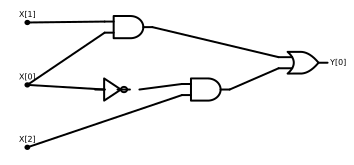

In [5]:
# (a ∧ b) ∨ (¬a ∧ c)
C = circuit(lambda a,b,c: OR( AND(a,b) , AND( NOT(a),c ) ) )
C

1

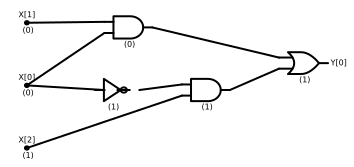

In [6]:
C(0,0,1, render = True)

In [7]:
table(C)

_Input_ | _Output_
--------|---------
  $000$  | $0$ 
  $001$  | $1$ 
  $010$  | $0$ 
  $011$  | $1$ 
  $100$  | $0$ 
  $101$  | $0$ 
  $110$  | $1$ 
  $111$  | $1$ 


gate_0 = AND(X[0],X[1])
gate_1 = NOT(X[0])
gate_2 = AND(gate_1,X[2])
Y[0] = OR(gate_0,gate_2)



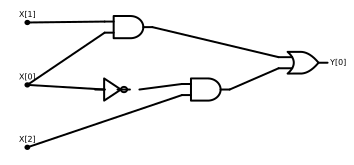

In [8]:
print(circuit2prog(C))
C.draw()

__Def I (3.5):__ <font color="red">_Boolean Circuit_</font> $C$ is a DAG where vertices  
are <font color="blue">_inputs_</font> labeled   `X[0]` ... `X[n-1]` or <font color="blue">_gates_</font>
labeled  $\wedge$/$\vee$/$\neg$.
<font color="blue">_Output gates_</font> are additionally labeled with  `Y[0]` ... `Y[m-1]`.<br>
For $x\in \{0,1\}^n$,  we denote the output of $C$ on input $x$ by $C(x)$.

__Def II (3.7):__ <font color="red">_AON-CIRC program_</font> $P$ has lines of form
`foo = AND(bar,blah)` , `foo = OR(bar,blah)` or `foo = NOT(blah)`. 
<font color="blue">_Input variables_</font> are named  `X[0]`,...,`X[n-1]`and 
<font color="blue">_output variables_</font> are named  `Y[0]`..`Y[m-1]`. <br>
For $x\in \{0,1\}^n$, we denote the output of $P$ on input $x$ by $P(x)$. 

__Theorem III (3.8):__ For every $f:\{0,1\}^n \rightarrow \{0,1\}^m$ and $s\in \mathbb{N}$, 
$f$ is computable by a Boolean circuit of $s$ gates if and only if 
$f$ is computable by an AON-CIRC program of $s$ lines.

In [9]:
def EVAL(code,X):
    """Evaluate code on input X."""
    n,m = numinout(code) # helper function - get number of inputs and outputs
    
    vtable = { f"X[{i}]":int(X[i]) for i in range(n)}
    
    for line in code.split("\n"):
        if not line: continue
        foo,op,bar,blah = parseline(line,2) 
        # helper function - split "foo = OP(,blah)" to list ["foo","OP","bar","blah"]
        # 2 is num of arguments to expect: blah is empty if it's missing
        if op=="NOT": vtable[foo] = NOT(vtable[bar])
        if op=="AND": vtable[foo] = AND(vtable[bar],vtable[blah])
        if op=="OR": vtable[foo] =  OR(vtable[bar],vtable[blah])
    
    return [vtable[f"Y[{j}]"] for j in range(m)]            

__Q:__ Write an AON-CIRC program that computes $XOR:\{0,1\}^2 \rightarrow \{0,1\}$ where $XOR(a,b) = a+b \mod 2$

code = r'''
foo = AND(X[0],X[1])
bar = NOT(foo)
or  = OR(X[0],X[1])
Y[0] = OR(foo,OR)'''[1:]

In [10]:
xorcode = r"""
t1      = AND(X[0],X[1])
nott1   = NOT(t1)
t2      = OR(X[0],X[1])
Y[0]    = AND(nott1,t2)
"""[1:]
table(xorcode)

_Input_ | _Output_
--------|---------
  $00$  | $0$ 
  $01$  | $1$ 
  $10$  | $1$ 
  $11$  | $0$ 


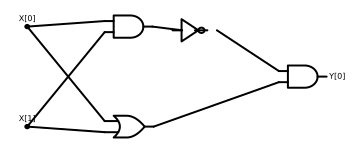

In [11]:
circuit(xorcode)

__Q:__ Write NAND-CIRC code to compute $XOR:\{0,1\}^2 \rightarrow \{0,1\}$ such that $XOR(a,b) = a+b \mod 2$.

Reminder AON-CIRC code is:
```python
t1      = AND(X[0],X[1])
nott1   = NOT(t1)
t2      = OR(X[0],X[1])
Y[0]    = AND(nott1,t2)
```

In [12]:
def parseline(line, numargs = 2):
    """Parse a line of the form foo = 'OP( bar1, bar2, bar3)'
       to ['foo','OP','bar1','bar2','bar2'].
       If numargs > number of arguments in line then add empty strings to the list as needed."""
    if not line: return [""]*(2+numargs)
    i = line.find("=")
    j = line.find("(")
    k = line.find(")")
    if i<0 or j<0 or k<0: raise Exception(f"Line not formatted properly: {line}")
    args = [a.strip() for a in line[j+1:k].split(",")]
    if len(args)<numargs: args += [""]*(numargs-len(args))
    return [line[:i].strip() , line[i+1:j].strip()] + args

In [13]:
def AON2NAND(code):
    output = ""; counter = 0
    for line in code.split("\n"):
        foo,op,bar,blah = parseline(line) 
        # helper: parses "foo = op(bar,blah)"
        if op=="NOT":
            output += f"{foo} = NAND({bar},{bar})\n"
        if op=="AND": 
            output += f"temp_{counter} = NAND({bar},{blah})\n"
            output += f"{foo} = NAND(temp_{counter},temp_{counter})\n"
            counter +=1
        if op=="OR":
            output += f"temp_{counter} = NAND({bar},{bar})\n"
            output += f"temp_{counter+1} = NAND({blah},{blah})\n"
            output += f"{foo} = NAND(temp_{counter},temp_{counter+1})\n"
            counter +=2
    return output

In [14]:
xornand = AON2NAND(xorcode)
print(xornand)

temp_0 = NAND(X[0],X[1])
t1 = NAND(temp_0,temp_0)
nott1 = NAND(t1,t1)
temp_1 = NAND(X[0],X[0])
temp_2 = NAND(X[1],X[1])
t2 = NAND(temp_1,temp_2)
temp_3 = NAND(nott1,t2)
Y[0] = NAND(temp_3,temp_3)



_Input_ | _Output_
--------|---------
  $00$  | $0$ 
  $01$  | $1$ 
  $10$  | $1$ 
  $11$  | $0$ 


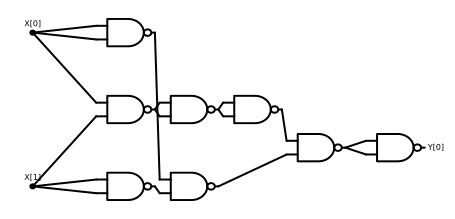

In [15]:
circuit(xornand).draw()
table(xornand)

In [16]:
# Q: what does this program compute?
mystery='''
u = NAND(X[0],X[1])
v = NAND(X[0],u)
w = NAND(X[1],u) 
Y[0] = NAND(v,w)'''[1:]

In [17]:
table(mystery)

_Input_ | _Output_
--------|---------
  $00$  | $0$ 
  $01$  | $1$ 
  $10$  | $1$ 
  $11$  | $0$ 


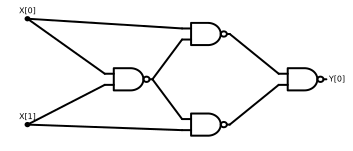

In [18]:
circuit(mystery)

__Q:__ Design a NAND circuit to compute $XOR4:\{0,1\}^4 \rightarrow \{0,1\}$ where $XOR4(a,b,c,d) = a+b+c+d \mod 2$

In [19]:
def XOR2(a,b):
    u = NAND(a,b)
    v = NAND(a,u)
    w = NAND(b,u)
    return NAND(v,w)

def XOR4(a,b,c,d):
    u = XOR2(a,b)
    v = XOR2(c,d)
    return XOR2(u,v)

XOR4circ = circuit(XOR4)

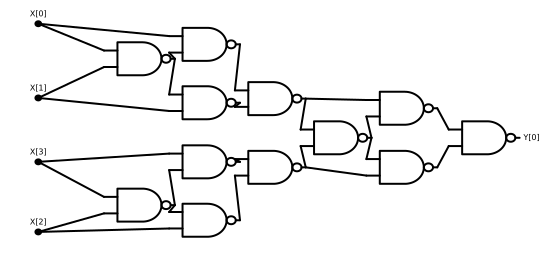

In [20]:
XOR4circ

In [21]:
table(XOR4circ)

_Input_ | _Output_
--------|---------
  $0000$  | $0$ 
  $0001$  | $1$ 
  $0010$  | $1$ 
  $0011$  | $0$ 
  $0100$  | $1$ 
  $0101$  | $0$ 
  $0110$  | $0$ 
  $0111$  | $1$ 
  $1000$  | $1$ 
  $1001$  | $0$ 
  $1010$  | $0$ 
  $1011$  | $1$ 
  $1100$  | $0$ 
  $1101$  | $1$ 
  $1110$  | $1$ 
  $1111$  | $0$ 


In [22]:
print(circuit2prog(XOR4circ))

gate_0 = NAND(X[0],X[1])
gate_1 = NAND(X[0],gate_0)
gate_2 = NAND(X[1],gate_0)
gate_3 = NAND(gate_1,gate_2)
gate_4 = NAND(X[2],X[3])
gate_5 = NAND(X[2],gate_4)
gate_6 = NAND(X[3],gate_4)
gate_7 = NAND(gate_5,gate_6)
gate_8 = NAND(gate_3,gate_7)
gate_9 = NAND(gate_3,gate_8)
gate_10 = NAND(gate_7,gate_8)
Y[0] = NAND(gate_9,gate_10)



## Next Up:

__Theorem:__ For _every_ function $f:\{0,1\}^n \rightarrow \{0,1\}^m$ there exists a Boolean circuit to compute $f$.

__Corollary:__ For every such $f$, there is AON-CIRC program/NAND circuit/NAND-CIRC program to compute $f$.

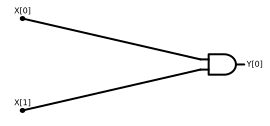

In [38]:
circuit(lambda a,b: AND(a,b))